In [1]:
!pip install -q --upgrade pip
!pip install -U jaxlib==0.4.2+cuda11.cudnn82 -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q --upgrade jax[cuda11_cudnn805] -f https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
!pip install -q git+https://www.github.com/google/neural-tangents
!pip3 install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cpu
!pip install pyg-lib torch-scatter torch-sparse torch-cluster torch-spline-conv torch-geometric -f https://data.pyg.org/whl/torch-1.13.0+cpu.html

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 14.6 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://storage.googleapis.com/jax-releases/jax_cuda_releases.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 164.4/164.4 MB 4.2 MB/s eta 0:00:00
  Attempting uninstall: jaxlib
    Found existing installation: jaxlib 0.4.4+cuda11.cudnn82
    Uninstalling jaxlib-0.4.4+cuda11.cudnn82:
      Successfully uninstalled jaxlib-0.4.4+cuda11.cudnn82
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.2/111.2 kB 10.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.7/79.7 kB 10.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 17.3/17.3 MB 84.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 34.5/34.5 MB 13.9 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that ar

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd /content/drive/MyDrive/Colab Notebooks/Masterarbeit/two_WL_NTK

Mounted at /content/drive
/content/drive/MyDrive/Colab Notebooks/Masterarbeit/two_WL_NTK


In [3]:
%cd /content/drive/MyDrive/Colab Notebooks/Masterarbeit/two_WL_NTK

/content/drive/MyDrive/Colab Notebooks/Masterarbeit/two_WL_NTK


In [4]:
from utils import *
import os

# from sklearn import metrics
import neural_tangents as nt
from neural_tangents import stax
from jax import numpy as np
from jax import random
import jax
from jax import numpy as np
from jax import jit, grad, vmap
from jax.example_libraries import optimizers
from jax import random
import matplotlib.pyplot as plt
from jax.nn import log_softmax
from data_preperation import *
from torch_geometric.datasets import TUDataset
from torch_geometric.loader import DataLoader

In [5]:
def balance(ys):
  one_indices = np.array(np.nonzero(ys))[0,:]
  zero_indices = np.array(np.nonzero(ys==0))[0,:]

  one_count = int(one_indices.shape[0])
  zero_count = int(zero_indices.shape[0])

  if one_count > zero_count:
    one_indices = one_indices[:zero_count]
  else:
    zero_indices = zero_indices[:one_count]

  indices = np.append(one_indices, zero_indices)

  # shuffel the indices
  key = random.PRNGKey(0)
  key, subkey = jax.random.split(key)
  indices = random.permutation(subkey, indices)

  return indices

In [6]:
# load preprocessed data

dataset_name = "MUTAG"
base_path = f"/content/drive/MyDrive/MasterarbeitData/Preprocessed/{dataset_name}"

ys = np.load(base_path + f"/ys.npy")
graphs_edge_features = np.load(base_path + f"/graphs_edge_features.npy")
graph_two_wl_pattern = np.load(base_path + f"/two_wl_pattern_radius_1.npy")

# shouldnt this be 
# batch x #nodes x 1 x #channels ?
print(graphs_edge_features.shape)
print(graph_two_wl_pattern.shape)

(188, 28, 28, 8)
(376, 4)


In [ ]:
# that is wrong!?
# the edege featue shape is batch x #nodes x #nodes x #channels
# reshape to:
# batch x #nodes x 1 x #channels
# we need the 1 in axis 2, that we can use convolution layer
# graps_node_features = np.swapaxes(graphs_edge_features, 2, 3)
# graps_node_features.shape

In [10]:
# split the data into folds for cross validation
key = random.PRNGKey(0)
key, subkey = jax.random.split(key)
batch_index = np.squeeze(random.randint(subkey, (188,1), 0, 10))

In [7]:
from layers import two_wl_aggregation

n_nodes = 28
layer_wide = 32
# for input "kernel_fn(x1, x2, 'ntk', pattern = (p1,p2))"
# the shape of the kernel after the convolution is:
# x1 = (b1, h1, w1, c1)
# x2 = (b2, h2, w2, c2)
# k = (b1, b2, h1, h2, w1, w2) 


L_branche = stax.serial(
    stax.Conv(layer_wide, (1,1), parameterization="standard"),
    )

Gamma_branche = stax.serial(
    stax.Conv(layer_wide, (1,1), parameterization="standard"),
    two_wl_aggregation(n_nodes),
)

two_wl_aggregation_layer = stax.serial(
    stax.FanOut(2), 
    stax.parallel(L_branche, Gamma_branche),
    stax.FanInSum(),
    stax.Relu(),
    )


init_fn, apply_fn, kernel_fn = stax.serial(
    two_wl_aggregation_layer,
    two_wl_aggregation_layer,
    two_wl_aggregation_layer,
    #two_wl_aggregation_layer,
    #two_wl_aggregation_layer,
    #two_wl_aggregation_layer,
    #two_wl_aggregation_layer,
    #two_wl_aggregation_layer,
    #two_wl_aggregation_layer,
    #two_wl_aggregation_layer,
    #two_wl_aggregation_layer, # k = (b1, b2, h1, h2, w1, w2)
    stax.GlobalSumPool(), # # k = (b1, b2)
    stax.Dense(1),
)




In [8]:
def accuracy(ys, logits):
  return np.mean((logits > 0) == ys)

def cross_entropy(ys, logits):
  log_p = jax.nn.log_sigmoid(logits)
  log_not_p = jax.nn.log_sigmoid(-logits)
  return np.mean(-ys * log_p - (1 - ys) * log_not_p)

loss = jit(cross_entropy)
grad_loss = jit(grad(lambda params, x, y, pattern: loss(y, apply_fn(params, x, pattern=pattern))))

We need the edge features!!!

In [11]:
# initialize the paramters and the optimzer 
learning_rate =  0.0001

key, subkey = jax.random.split(key)
_, params = init_fn(subkey, graphs_edge_features.shape)

opt_init, opt_apply, get_params = optimizers.adam(learning_rate)
opt_apply = jit(opt_apply)
state = opt_init(params)

In [ ]:
apply_fn(params, graphs_edge_features, pattern=graph_two_wl_pattern).shape

(188, 1)

In [ ]:
grad_loss(params, graphs_edge_features, ys, graph_two_wl_pattern)

[[(), ([(Array([[[[ 0.00000000e+00,  0.00000000e+00, -1.12736091e-01,
                0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00],
              [ 0.00000000e+00, -4.86605652e-02, -1.02607673e-02,
                0.00000000e+00,  3.04728188e-02,  0.00000000e+00,
                0.00000000e+00],
              [ 1.12076830e-02,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00,  2.14192159e-02,  7.87935778e-03,
               -4.76685679e-03],
              [-1.33992784e-04,  1.03975006e-04,  0.00000000e+00,
                0.00000000e+00, -8.73442041e-05, -7.88736506e-05,
                0.00000000e+00],
              [ 3.44209257e-05, -6.50720322e-05,  3.04577879e-05,
                2.59164281e-05,  8.46432667e-05,  0.00000000e+00,
               -3.06156835e-05],
              [-6.92141708e-04,  0.00000000e+00,  0.00000000e+00,
                0.00000000e+00,  0.00000000e+00, -4.86597593e-04,
                2.94382131e-04],
      

In [ ]:
params = get_params(state)
state = opt_apply(0, grad_loss(params, graphs_edge_features, ys, graph_two_wl_pattern), state)
params = get_params(state)

In [ ]:
apply_fn(params, graphs_edge_features, pattern=graph_two_wl_pattern)[0]


Array([0.06820484], dtype=float32)

In [13]:
epochs = 200

train_losses = []
val_losses = []
params_evolution = []
val_acc = []

for epoch in range(epochs):
  print(epoch)

  key, subkey = jax.random.split(key)
  hold_out_batch = np.squeeze(random.randint(subkey, (1,1), 0, 10))
  hold_out_indx = hold_out_batch == batch_index
  pattern_hold_out_indx = graph_two_wl_pattern[:,0] == hold_out_batch

  xs_val = graphs_edge_features[hold_out_indx,:]
  pattern_val = graph_two_wl_pattern[pattern_hold_out_indx,:]
  ys_val = ys[hold_out_indx,:]

  xs_train = graphs_edge_features[~hold_out_indx,:]
  pattern_train = graph_two_wl_pattern[~pattern_hold_out_indx,:]
  ys_train = ys[~hold_out_indx,:]

  # balance the classes for the traig
  balanced_indices_train = balance(ys_train)
  xs_train = xs_train[balanced_indices_train,:]
  pattern_train = pattern_train[balanced_indices_train,:]
  ys_train = ys_train[balanced_indices_train,:]

  params = get_params(state)
  params_evolution.append(params)
  state = opt_apply(epoch, grad_loss(params, xs_train, ys_train, pattern_train), state)

  params = get_params(state)
  train_losses += [loss(ys_train, apply_fn(params, xs_train, pattern=pattern_train))]
  val_losses += [loss(ys_val, apply_fn(params, xs_val, pattern=pattern_val))]
  #val_auc += [metrics.roc_auc_score(ys_val, apply_fn(params, xs_val, pattern=pattern_val))]
  val_acc += [accuracy(ys_val, apply_fn(params, xs_val, pattern=pattern_val))]

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


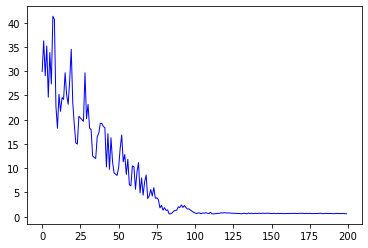

In [14]:
plt.plot(np.array(range(epochs)), np.array(val_losses), 'b-', linewidth=1)

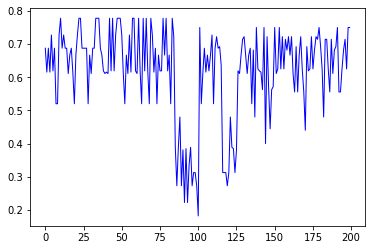

In [15]:
plt.plot(np.array(range(epochs)), np.array(val_acc), 'b-', linewidth=1)

In [16]:
np.mean(np.array(val_acc[-10:]))

Array(0.66995233, dtype=float32)

In [ ]:
accuracy(ys_val, apply_fn(params, xs_val, pattern=pattern_val))

In [ ]:
np.mean(ys_train)

In [ ]:
epochs = 200
train_losses = []
val_losses = []
params_evolution = []
val_auc = []

for epoch in range(epochs):
  print(epoch)

  key, subkey = jax.random.split(key)
  hold_out_batch = np.squeeze(random.randint(subkey, (1,1), 0, 10))
  hold_out_indx = hold_out_batch == batch_index

  xs_val = graps_node_features[hold_out_indx,:]
  pattern_val = graph_conv_pattern[hold_out_indx,:]
  ys_val = ys[hold_out_indx,:]

  for i in range(10):
    if i == int(hold_out_batch):
      next

    batch_indx = i == batch_index
    
    xs_train = graps_node_features[batch_indx,:]
    pattern_train = graph_conv_pattern[batch_indx,:]
    ys_train = ys[batch_indx,:]

    params = get_params(state)
    params_evolution.append(params)
    state = opt_apply(i, grad_loss(params, xs_train, ys_train, pattern_train), state)

  params = get_params(state)
  train_losses += [loss(ys_train, apply_fn(params, xs_train, pattern=pattern_train))]
  val_losses += [loss(ys_val, apply_fn(params, xs_val, pattern=pattern_val))]
  val_auc += [metrics.roc_auc_score(ys_val, apply_fn(params, xs_val, pattern=pattern_val))]

In [ ]:
np.mean((params_evolution[0][1][0] - params_evolution[80][1][0])**2)

In [ ]:
ys_val

In [ ]:
y_hat.shape

In [ ]:
ys_train.shape

In [ ]:
loss(ys_val, y_hat)

In [ ]:
cross_entropy = lambda fx, y_hat: -np.mean(log_softmax(fx) * y_hat)

In [ ]:
-(ys_val*np.log(y_hat) + (1-ys_val)*np.log(1-y_hat))

In [ ]:
log_softmax(y_hat)